# 5 - Algoritmos de regresión

Los algoritmos de **regresión** son el segundo de los dos tipos en los que pueden divisirse los algoritmos de **aprendizaje supervisado**. Estos algoritmos suponen que partimos de un conjunto de datos etiquetado previamente.

Un algoritmo de regresión se centra en resolver problemas en los cuales se debe predecir el valor de una variable continua $\mathbf{y}$ conocida el valor de la variable $\mathbf x$. En este problema la variable $\mathbf{x}$ se suele denominar **regresor** o **variable  explicativa** mientras que $\bf y$ se denomina **variable respuesta** o **variable  dependiente**.

Ya se ha visto cómo hacerregresión mediante técnicas estadísticas. En este caso se usarám los árboles, que yase han usado para clasificar.

In [ ]:
## Solicitar acceso y montar en el sistema tu directorio de Google Drive
# Esto permitirá la persistencia de datos entre distintas sesiones
import os, sys
from google.colab import drive
drive.mount('/content/drive')

# Creamos un directorio para este notebook y lo asociamos
drive_path = '/content/drive/MyDrive/Colab Notebooks/ia-bd-m4-sistemas-de-big-data'
nb_path = '/content/ia-bd-m4-sistemas-de-big-data'

if not os.path.exists(drive_path):
    os.makedirs(drive_path)
os.symlink(drive_path, nb_path)
sys.path.insert(0,nb_path)

%cd $nb_path

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ia-bd-m4-sistemas-de-big-data


## Instalación de spark en Google Colab

In [ ]:
# Spark está escrito en el lenguaje de programación Scala, por lo que requiere
# de una máquina virtual de Java (JVM) para funcionar. Por lo tanto, lo primero
# es instalar java:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
## Instalación de Apache Spark en Google Colab (Ejecutar solo si no se ha realizado nunca)
# Nota: Puede tardar unos minutos (se paciente)
# El siguiente paso es elegir una versión reciente de spark
# En este notebook, se usará spark versión 3.1.2, la cual puede descargarse en:
spark_file = 'spark-3.1.2-bin-hadoop3.2.tgz'
spark_url = 'https://archive.apache.org/dist/spark/spark-3.1.2/' + spark_file

# A continuación, descargamos la versión elegida de spark:
import os # Libreria de manejo del sistema operativo
os.system("wget -q {spark_url} -P " + nb_path) # Realizamos la descarga
os.system("tar xf " + nb_path + "/" + spark_file) # Descomprimimos el fichero .tgz

# Realizamos la instalación de pyspark utilizando la herramienta pip
!pip install --target=$nb_path -q pyspark
!pip install -q findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 20.7 MB/s eta 0:00:00


In [ ]:
# Damos permisos de ejecución
!chmod -R +x ./pyspark/

# Finalmente, es necesario definir algunas variables de entorno en el sistema
# operativo para poder usar spark correctamente:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = nb_path + "/pyspark"

## Cargar el conjunto de datos que se utilizará

En este caso utilizaremos un conjunto de datos completo sobre el uso de bicicletas de alquiler en una ciudad (*bikes.csv*). Este dataset puede descargarse [aquí](https://drive.google.com/file/d/1Vdkz8Qx0oTzQouwTVOlgazSU5_H6tghd).

**Descripción del problema.**

Una empresa de bicicletas compartidas que opera en el área de una ciudad específica. Esta empresa tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar una bicicleta desde un lugar en particular y devolverla en un lugar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro en función de las condiciones meteorológicas. Para ello se nos facilita un archivo [csv](https://drive.google.com/file/d/1Vdkz8Qx0oTzQouwTVOlgazSU5_H6tghd) donde aparecen el número de bicicletas contratadas todos los días ("count") y las variables meteorológicas de esos días ("temperature", "humidity", "windspeed").

Se usará análisis de regresión con el fin de capturar la relación entre características y número de bicicletas contratadas en un modelo.

In [ ]:
# Descargar el dataset que se utilizará utilizando un enlace compartido de google drive
# El fichero puede descargarse directamente de la fuente proporcionada, o se
# puede utilizar el siguiente código para descargarlo de google drive:
# URL: https://drive.google.com/file/d/1Vdkz8Qx0oTzQouwTVOlgazSU5_H6tghd
!gdown --id 1Vdkz8Qx0oTzQouwTVOlgazSU5_H6tghd

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Vdkz8Qx0oTzQouwTVOlgazSU5_H6tghd
To: /content/drive/MyDrive/Colab Notebooks/ia-bd-m4-sistemas-de-big-data/bikes.csv
100% 54.2k/54.2k [00:00<00:00, 75.5MB/s]


Creamos un cluster de Spark e importamos el dataframe actual en Spark.

In [ ]:
# Importar pyspark.sql
from pyspark.sql import*

# Importar SparkContext and SparkConf
from pyspark import SparkContext, SparkConf

# Establecer las propiedades de Spark:
# - URL de conexión
# - Nombre de la aplicación
conf = SparkConf().setMaster("local").setAppName("5-Algoritmos-de-regresion")

# Iniciar un cluster de Spark (puede tardar unos minutos)
# Comprobar si ya existe este cluster y en el caso contrario crear uno nuevo
sc = SparkContext.getOrCreate(conf=conf)

# Mostramos el cluster creado
sc

<SparkContext master=local appName=5-Algoritmos-de-regresion>

In [ ]:
# Inicializar SQLContext a partir del cluster Spark creado anteriormente
sqlContext = SQLContext(sc)

# Creamos un dataframe a partir del archivo CSV descargado anteriormente y
# que contiene el dataset que utilizaremos en esta sesión
df = sqlContext.read.csv('bikes.csv', header=True, sep=",", inferSchema = "true")

# Mostrar el contenido del dataframe (las 5 primeras observaciones)
df.show(5)

/content/ia-bd-m4-sistemas-de-big-data/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+----------+------------------+------------------+------------------+-----+
|      date|       temperature|          humidity|         windspeed|count|
+----------+------------------+------------------+------------------+-----+
|2011-01-03| 2.716069662931224|45.715345912596405|21.414956510619877|120.0|
|2011-01-04|2.8966732970082774|54.267219023136256|15.136881890530196|108.0|
|2011-01-05|  4.23565354008174| 45.69770190231361|17.034577653575038| 82.0|
|2011-01-06|3.1126426592104286| 50.23734940874036|10.091567671737069| 88.0|
|2011-01-07|2.7239176756331425| 49.14492832904885|15.738204070746255|148.0|
+----------+------------------+------------------+------------------+-----+
only showing top 5 rows



## Pre-procesamiento del dataset y obtención de conjuntos de entrenamiento y test

Utilizaremos el *VectorAssembler* para generar una nueva columna en el dataframe la cual tendrá un vector del tipo DenseVector conteniendo todas las características del dataset. Recordad que este era un paso necesario antes de aplicar cualquier algoritmo de ML de la biblioteca [MLlib de Spark](https://spark.apache.org/docs/latest/ml-guide.html).

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
  inputCols = ['temperature', 'humidity', 'windspeed'],
  outputCol = "features"
)
df = assembler.transform(df)

# Mostramos la nueva columa "features" para las 5 primeras filas del dataset
df.select("features").show(5, truncate=False)

+----------------------------------------------------------+
|features                                                  |
+----------------------------------------------------------+
|[2.716069662931224,45.715345912596405,21.414956510619877] |
|[2.8966732970082774,54.267219023136256,15.136881890530196]|
|[4.23565354008174,45.69770190231361,17.034577653575038]   |
|[3.1126426592104286,50.23734940874036,10.091567671737069] |
|[2.7239176756331425,49.14492832904885,15.738204070746255] |
+----------------------------------------------------------+
only showing top 5 rows



En este caso no vamos a escalar los datos. Queremos usar los valores reales.

Ahora vamos a dividir el dataset en un conjunto de entrenamiento y otro de test. Gracias a esto, podremos estimar cada modelo sobre el conjunto de entrenamiento, utilizando el conjunto de test para validar los resultados obtenidos.

In [ ]:
# Dividimos entre entrenamiento (primeras 363 filas, el primer año)
# y test (las filas restantes, el segundo año)
train_df = df.limit(363)
test_df = df.subtract(train_df).sort("date")

print("Número de filas df entrenamiento: {train:d}".format(train=train_df.count()))
print("Número de filas df test: {test:d}".format(test=test_df.count()))

Número de filas df entrenamiento: 363
Número de filas df test: 366


In [ ]:
train_df.show(5)
test_df.show(5)

+----------+------------------+------------------+------------------+-----+--------------------+
|      date|       temperature|          humidity|         windspeed|count|            features|
+----------+------------------+------------------+------------------+-----+--------------------+
|2011-01-03| 2.716069662931224|45.715345912596405|21.414956510619877|120.0|[2.71606966293122...|
|2011-01-04|2.8966732970082774|54.267219023136256|15.136881890530196|108.0|[2.89667329700827...|
|2011-01-05|  4.23565354008174| 45.69770190231361|17.034577653575038| 82.0|[4.23565354008174...|
|2011-01-06|3.1126426592104286| 50.23734940874036|10.091567671737069| 88.0|[3.11264265921042...|
|2011-01-07|2.7239176756331425| 49.14492832904885|15.738204070746255|148.0|[2.72391767563314...|
+----------+------------------+------------------+------------------+-----+--------------------+
only showing top 5 rows

+----------+-------------------+------------------+------------------+-----+--------------------+
|   

## Árboles de Decisión - Random Forest regression

Para más información sobre la implementación de PySpark sobre el algoritmo random forest regression puede consultar la [documentación de la API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html#pyspark.ml.regression.RandomForestRegressor).

**Ajuste de hiperparámetros del modelo.**

Mediante el uso del objeto CrossValidator se puede dividir el conjunto de datos en un subconjunto de pliegues (folds) que se utilizan como conjuntos de datos de entrenamiento y de prueba separados. Esta técnica se conoce como cross-validación. Por ejemplo, con k=3 pliegues, CrossValidator generará 3 pares de conjuntos de datos (de entrenamiento, de prueba), cada uno de los cuales utiliza 2/3 de los datos para el entrenamiento y 1/3 para la prueba. Para evaluar cada conjunto de parámetros posibles, CrossValidator calcula la métrica de evaluación media para los 3 modelos producidos al ajustar el estimador en los 3 pares de conjuntos de datos diferentes (entrenamiento, prueba).

LA diferencia con la ejecución es que para evaluar no podemos usar una métrica de clasificación si no una de Regresión. En este caso rmse (error cuadrático medio)

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(labelCol="count", featuresCol="features")

# Definimos los parámetros del grid donde se buscarán los parámetros óptimos
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [3, 6, 10]) \
    .addGrid(rf.numTrees, [50, 100, 150, 250]) \
    .build()

# Utilizaremos como metrica de evaluación el error cuadrático medio (RMSE)
evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction",
                                metricName="rmse")

# Definimos la cross-validación
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Ejecutar la cross-validación y elegir el mejor conjunto de parámetros
cvModel = crossval.fit(train_df)

print("MaxDepth: " + str(cvModel.bestModel.getMaxDepth()))
print("NumTrees: " + str(cvModel.bestModel.getNumTrees))

MaxDepth: 10
NumTrees: 250


**Entrenamiento del modelo.**

In [ ]:
# Entrenar un modelo de regresión usando random forest regressor
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="count", featuresCol="features",
                           maxDepth=10, numTrees=250, seed=10)

rf_model = rf.fit(train_df)
pred = rf_model.transform(test_df)

# Mostramos los valores reales junto con las predicciones realizadas
pred.select("date", "features", "count", "prediction").show(10)

+----------+--------------------+-----+------------------+
|      date|            features|count|        prediction|
+----------+--------------------+-----+------------------+
|2012-01-01|[4.42820304159430...|290.0|202.94549567785143|
|2012-01-02|[2.42066400760538...|189.5|106.60589643689646|
|2012-01-03|[0.41312497361646...| 89.0| 97.86675146335148|
|2012-01-04|[-1.6978911012665...| 95.0|168.62518591778596|
|2012-01-05|[6.16666203248534...|140.0|244.84427224133228|
|2012-01-06|[9.56087785509847...|307.0|282.09032593435154|
|2012-01-07|[7.73960908461114...|240.0| 287.4775178264264|
|2012-01-08|[5.91834031412380...|173.0|197.55797299313784|
|2012-01-09|[4.09707154363647...|106.0|194.40520613830608|
|2012-01-10|[8.29570866819621...|173.0| 275.2288941410779|
+----------+--------------------+-----+------------------+
only showing top 10 rows



In [ ]:
# Mostrar algunos parámetros del modelo, como la importancia de cada variable
print("Importancia de las variables: " + str(rf_model.featureImportances))

Importancia de las variables: (3,[0,1,2],[0.7009462110329349,0.16429428571961646,0.13475950324744873])


**Evaluación del modelo.**


Vamos a ver cómo se comporta el modelo en los datos de test, utilizando para ello el objeto *RegressionEvaluator* de Spark. Esta utilidad nos permitirá definir diferentes métricas para medir lo bien o mal que ajusta nuestro modelo de regresión a los datos reales.

Existen una gran varidad de métricas, cada una de las cuales tiene sus fortalezas y debilidades. No obstante, esto queda fuera de los contenidos de este curso y se estudiarán en el módulo de Sistemas de Aprendizaje Automático.

A modo de ejemplo, en este cuaderno se calculan 3 de las métricas más comunes que se utilizan para medir la precisión de las variables continuas:
* **Error cuadrático medio (RMSE)**: RMSE es una regla de puntuación cuadrática que también mide la magnitud media del error.
* **Error absoluto medio (MAE)**: MAE mide la magnitud promedio de los errores en un conjunto de predicciones, sin considerar su dirección.
* **Coeficiente de determinación ($R^2$)**: El valor $R^2$ mide el porcentaje de variación de la variable de respuesta con respecto una o más variables predictoras. Por lo general, un mayor valor de $R^2$ implica un mejor ajuste del modelo a sus datos. El $R^2$ siempre se encuentra entre 0 y 1.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="forgery", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.9801980198019802


Podremos observar también la **matriz de confusión**.
La matriz de confusión es una herramienta muy útil para valorar cómo de bueno es un modelo clasificación. En particular, sirve para mostrar de forma explícita cuándo una clase es confundida con otra. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real.

Para ello, lo primero que haremos será crear un nuevo dataframe solo con las prediciones y la clase real (los resultados corectos, es decir, la columna "forgery"). Posteriormente, tenemos que hacer un casting a la columna "forgery" para pasarla de entero a float, ya que la función para obtener la matriz de confusión solo funcionará con floats. Por último, mapeamos el dataframe en un RDD como una tupla y pasamos esta a la función MulticlassMetrics de MLlib.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction")

rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
print("Error cuadrático medio (RMSE): {}".format(rmse))
mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})
print("Error absoluto medio (MAE): {}".format(mae))
r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
print("Coeficiente de determinación R^2: {}".format(r2))

Error cuadrático medio (RMSE): 340.40167858206325
Error absoluto medio (MAE): 259.38405629991786
Coeficiente de determinación R^2: 0.31593559940374893


**Visualizar la predicción.**

Por último, podemos probar a visualizar como ha quedado nuestra predicción con respecto a la realidad.

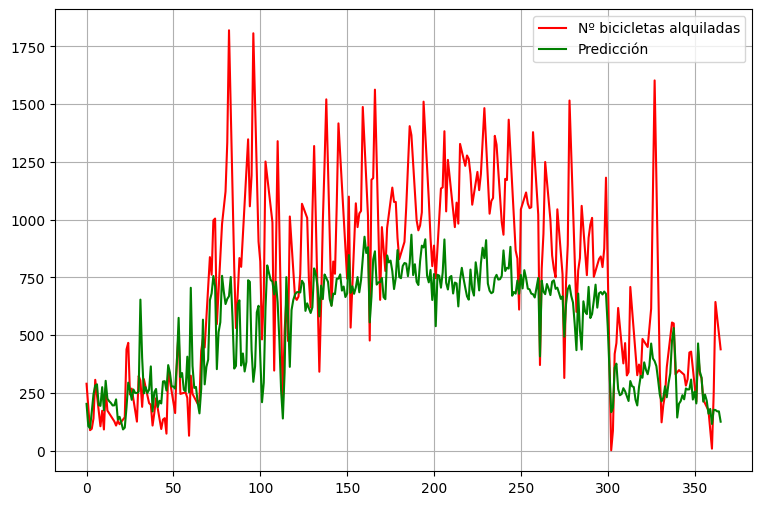

In [ ]:
# Obtenemos de Spark los datos de uso real de las bicicletas y las prediciones
# (cuidado con no desbordar la memoria)
import numpy as np
collected_data = np.array(pred.select("count", "prediction").collect())

# Ahora podemos visualizar en el eje X los días y en el eje Y el número de bicicletas
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(collected_data[:, 0], c="r", label="Nº bicicletas alquiladas")
plt.plot(collected_data[:, 1], c="g", label="Predicción")
plt.legend()
plt.grid()
plt.show()

## Árboles de Decisión - Gradient-boosted tree regression

Para más información sobre la implementación de PySpark sobre el algoritmo gradient-boosted tree regression puede consultar la [documentación de la API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.GBTRegressor.html#pyspark.ml.regression.GBTRegressor).

**Ajuste de hiperparámetros del modelo.**

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

gbt = GBTRegressor(labelCol="count", featuresCol="features")

# Definimos los parámetros del grid donde se buscarán los parámetros óptimos
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 6, 10]) \
    .build()

# Utilizaremos como metrica de evaluación el error cuadrático medio (RMSE)
evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction",
                                metricName="rmse")

# Definimos la cross-validación
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Ejecutar la cross-validación y elegir el mejor conjunto de parámetros
cvModel = crossval.fit(train_df)

print("MaxDepth: " + str(cvModel.bestModel.getMaxDepth()))

MaxDepth: 3


**Entrenamiento del modelo.**

In [ ]:
# Entrenar un modelo de regresión usando random forest regressor
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(labelCol="count", featuresCol="features",
                   maxDepth=3, seed=10)

gbt_model = gbt.fit(train_df)
pred = gbt_model.transform(test_df)

# Mostramos los valores reales junto con las predicciones realizadas
pred.select("date", "features", "count", "prediction").show(10)

+----------+--------------------+-----+------------------+
|      date|            features|count|        prediction|
+----------+--------------------+-----+------------------+
|2012-01-01|[4.42820304159430...|290.0| 126.4652375208222|
|2012-01-02|[2.42066400760538...|189.5|27.833535752743295|
|2012-01-03|[0.41312497361646...| 89.0|34.714730537132695|
|2012-01-04|[-1.6978911012665...| 95.0| 69.97887601129571|
|2012-01-05|[6.16666203248534...|140.0| 279.2361034687045|
|2012-01-06|[9.56087785509847...|307.0| 299.3607472825867|
|2012-01-07|[7.73960908461114...|240.0| 279.2361034687045|
|2012-01-08|[5.91834031412380...|173.0| 141.4124173364949|
|2012-01-09|[4.09707154363647...|106.0|121.51557385523986|
|2012-01-10|[8.29570866819621...|173.0| 270.1077262039334|
+----------+--------------------+-----+------------------+
only showing top 10 rows



**Evaluación del modelo.**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="count", predictionCol="prediction")

rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
print("Error cuadrático medio (RMSE): {}".format(rmse))
mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})
print("Error absoluto medio (MAE): {}".format(mae))
r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
print("Coeficiente de determinación R^2: {}".format(r2))

Error cuadrático medio (RMSE): 337.57361869160275
Error absoluto medio (MAE): 255.1019089680676
Coeficiente de determinación R^2: 0.32725480834010756


**Visualizar la predicción.**

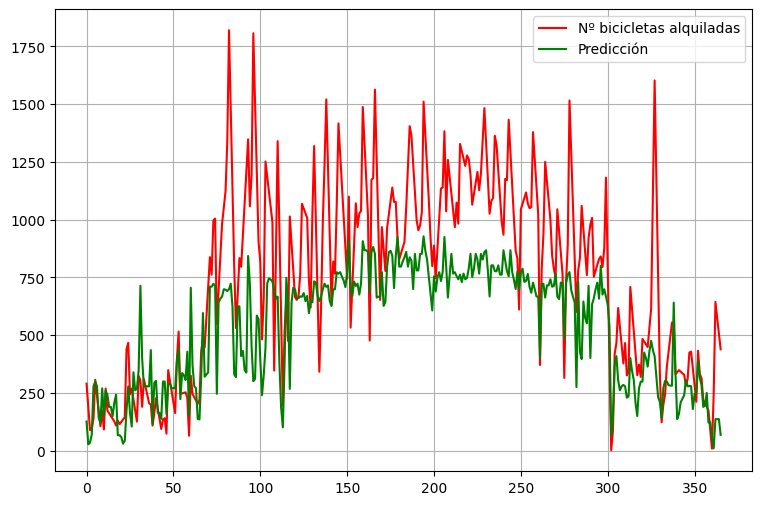

In [ ]:
# Obtenemos de Spark los datos de uso real de las bicicletas y las prediciones
# (cuidado con no desbordar la memoria)
import numpy as np
collected_data = np.array(pred.select("count", "prediction").collect())

# Ahora podemos visualizar en el eje X los días y en el eje Y el número de bicicletas
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 6))
plt.plot(collected_data[:, 0], c="r", label="Nº bicicletas alquiladas")
plt.plot(collected_data[:, 1], c="g", label="Predicción")
plt.legend()
plt.grid()
plt.show()